In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score, silhouette_samples


#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import preprocessing
import warnings
from kneed import KneeLocator

warnings.filterwarnings('ignore')

In [2]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [27]:
df = pd.read_csv(r"data/data_understanding_output.csv",skipinitialspace=True)
df_train = df.drop(['word','PoS','polysemy', 'length', 'number_of_meanings', 'avg_variance_between_meanings', 'log_freq', 'sentiment'], axis=1)
df_train.dtypes

arousal         float64
valence         float64
dominance       float64
imageability    float64
familiarity     float64
gender          float64
dtype: object

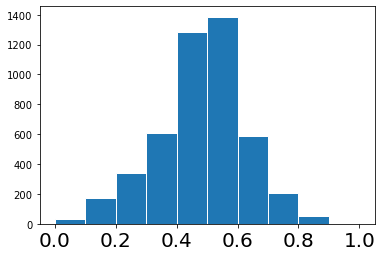

In [4]:
cols = [col for col in df_train.columns]
X = df[cols].values
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

plt.hist(X_minmax[:,2], edgecolor='white')

plt.xticks(fontsize=20)
plt.show()

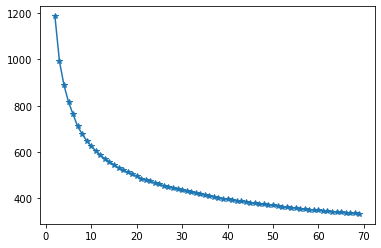

In [5]:
# kmeans
sse_list = list()
max_k = 70
#plt.figure((12,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100, )
    kmeans.fit(X_minmax)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list, marker='*')
plt.show()

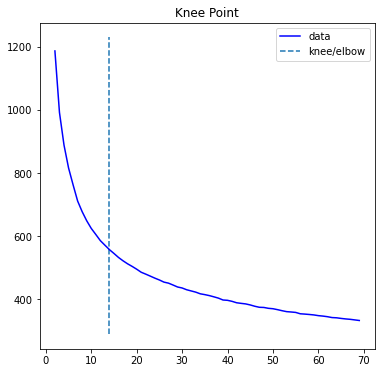

In [6]:
kl = KneeLocator(range(2, 70), sse_list, curve="convex", direction="decreasing")
kl.plot_knee()

In [7]:
print("knee: ", kl.knee)
print("elbow: ", kl.elbow)

knee:  14
elbow:  14


For n_clusters = 12 The average silhouette_score is : 0.15571561687095015
For n_clusters = 13 The average silhouette_score is : 0.15427977631354706
For n_clusters = 14 The average silhouette_score is : 0.14927148290697212
For n_clusters = 15 The average silhouette_score is : 0.15083609594229364
For n_clusters = 16 The average silhouette_score is : 0.15141585104820576


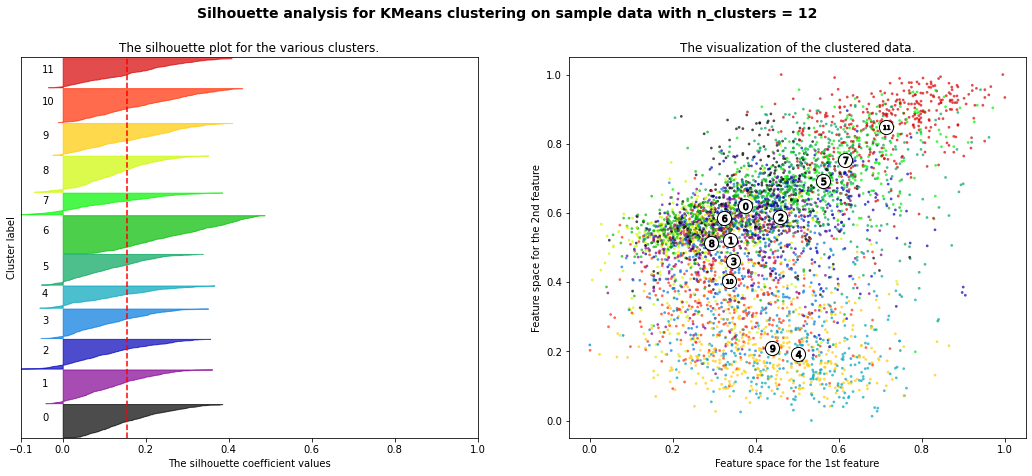

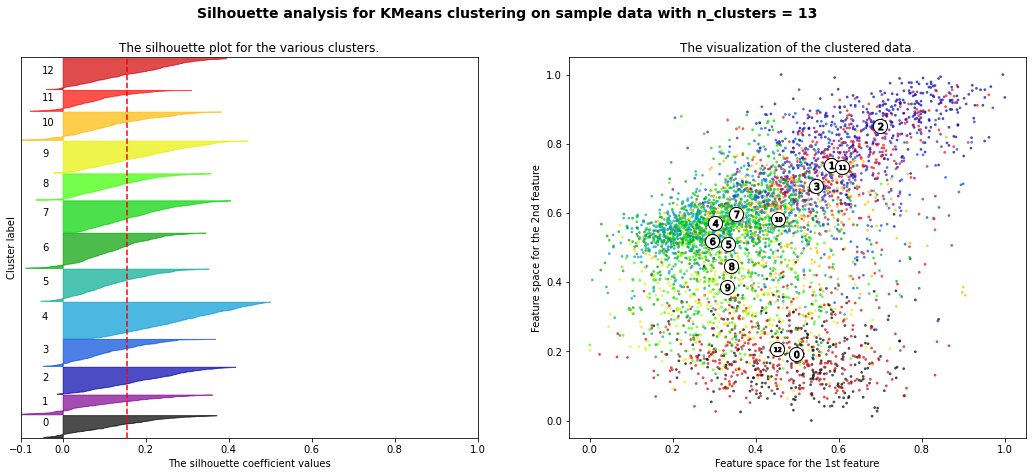

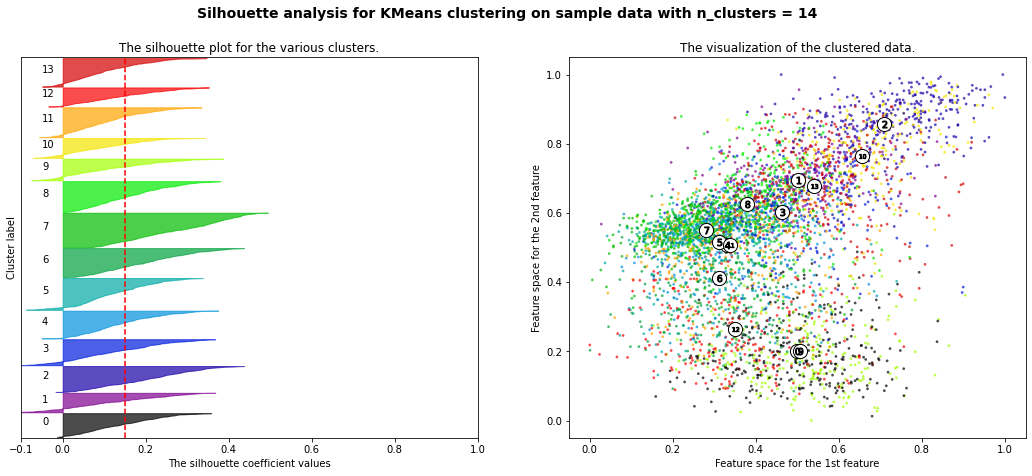

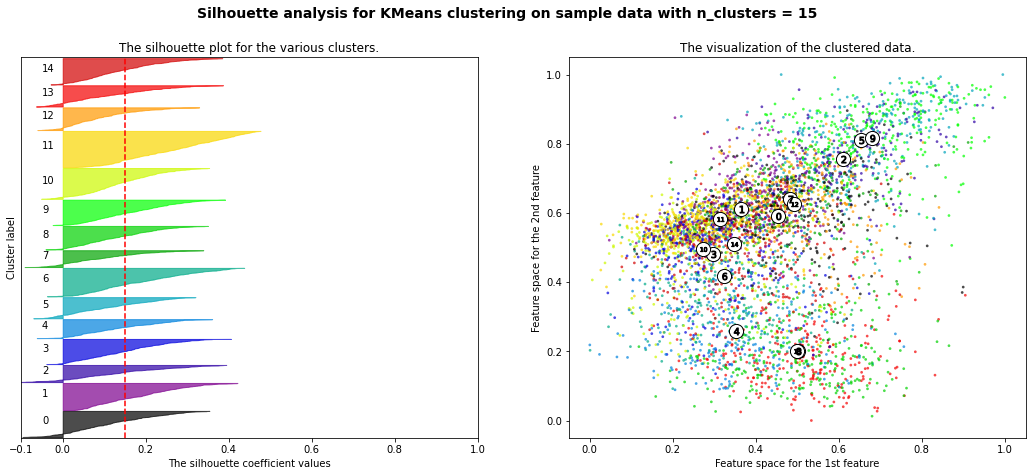

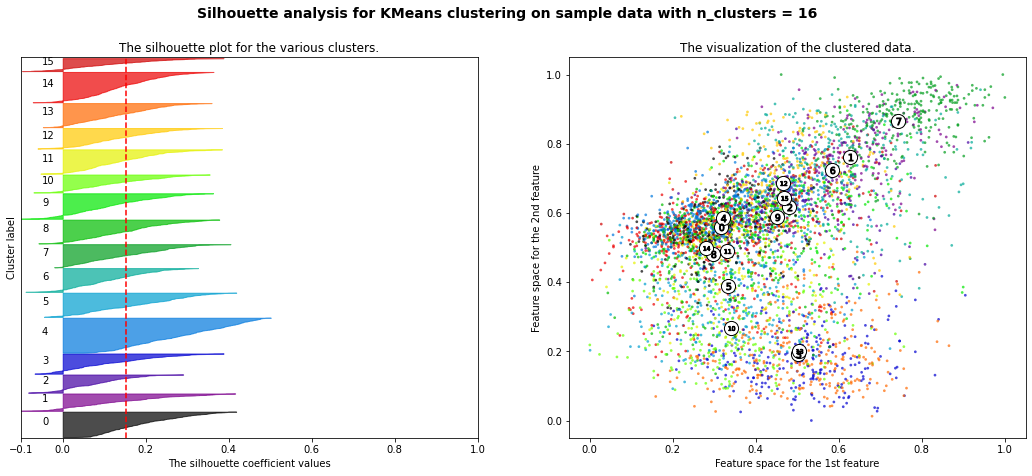

In [8]:
range_n_clusters = [12, 13, 14, 15, 16]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_minmax) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_minmax)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_minmax, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_minmax, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_minmax[:, 0], X_minmax[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [9]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)

k=20
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

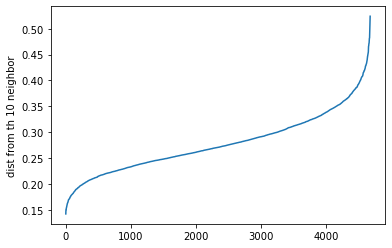

In [10]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from th 10 neighbor')
         
plt.show()

In [25]:
# density based clustering
print ('dbscan')

dbscan = DBSCAN(eps=0.8, min_samples=10, metric='euclidean')
dbscan.fit(X_minmax)


dbscan


DBSCAN(eps=0.8, min_samples=10)

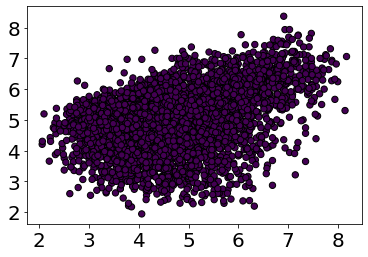

In [26]:
plt.scatter( X[:,0], X[:,2], s=40, edgecolor='black', c= dbscan.labels_ )

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()